In [1]:
from scipy.misc import imsave
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os
import ast

import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn

from tqdm import tqdm_notebook

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
folder = 'images/'

In [4]:
# read labels of Imagenet dataset 
with open('Imagenet_class_list.txt') as imagenet_class_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_class_file.read())

In [5]:
# 根据 imagenet 要求做变换
tran = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.486, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 恢复图像
def deprocess(img):
    img[0,:,:] = img[0,:,:] * 0.229 + 0.485
    img[1,:,:] = img[1,:,:] * 0.224 + 0.456
    img[2,:,:] = img[2,:,:] * 0.225 + 0.406
    return img
def restoreImg_from_tensor(img_tensor):
    pro_img = img_tensor.data.numpy()
    pro_img = pro_img.copy()
    pro_img = pro_img.squeeze(0)
    pro_img = deprocess(pro_img)
    pro_img = pro_img.transpose(1,2,0)
    return pro_img

def create_title(category, proba):
    return '"%s" %.1f%% confidence' % (category.replace('_', ' '), proba * 100)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def generate_title(model, array):
    pred = model(array)
    ind = int(np.argmax(pred.data[0]))
    label = imagenet_classes_dict[ind]
    prob = softmax(pred.data[0].numpy())
    
    return ind, label, prob[ind]

In [6]:
def attack_example(model, img):
    sigma = 0.03
    
    pred = model(img)
    ind = pred.argmax()
    labels = ind.data.numpy().tolist()
    input_holder = Variable(img, requires_grad = True)
    out = model(input_holder)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, Variable(ind.view(1)))
    
    loss.backward()
    
    signs = torch.sign(input_holder.grad.data)

    input_holder.data = input_holder.data + sigma * signs
    
    return input_holder, signs

In [20]:
def generate_adversarial_examples(folder, title, perturbation_model,
                                  display_model = None, epsilon=0.03):
    if not display_model:
        display_model = perturbation_model
        
    filenames = os.listdir(folder)
    line_number = len(filenames)
    
    import pylab
    pylab.rcParams['figure.figsize'] = (12.0, 12.0)
    plt.figure(figsize=(7*3, 4 * line_number))
    
    for line in tqdm_notebook(range(len(filenames))):
        filename = filenames[line]
        original_array = Image.open(os.path.join(folder, filename))
        
        prepreocessed_array = tran(original_array)
        prepreocessed_array.unsqueeze_(dim=0)
        modified_img, perturbation = attack_example(perturbation_model,
                                                    prepreocessed_array)
        
        ori_title = generate_title(display_model, prepreocessed_array)
        pert_title = generate_title(display_model, perturbation)
        modi_title = generate_title(display_model, modified_img)
        
        plt.subplot(line_number, 3, 3 * line + 1)
        plt.imshow(original_array.resize((224,224)))
        plt.title(ori_title)
        plt.axis('off')
        
        plt.subplot(line_number, 3, 3 * line + 2)
        tmp = (perturbation.data.numpy().squeeze(0)).transpose(1,2,0)
        plt.imshow(tmp)
        plt.title(pert_title)
        plt.axis('off')
        
        plt.subplot(line_number, 3, 3* line + 3)
        plt.imshow(restoreImg_from_tensor(modified_img))
        plt.title(modi_title)
        plt.axis('off')
        
    plt.suptitle(title)
#     plt.tight_layout(pad=4)

In [8]:
vgg16 = tv.models.vgg16_bn(pretrained=True)
vgg16.eval()
resnet50 = tv.models.resnet50(pretrained=True)
resnet50.eval()

print('========')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

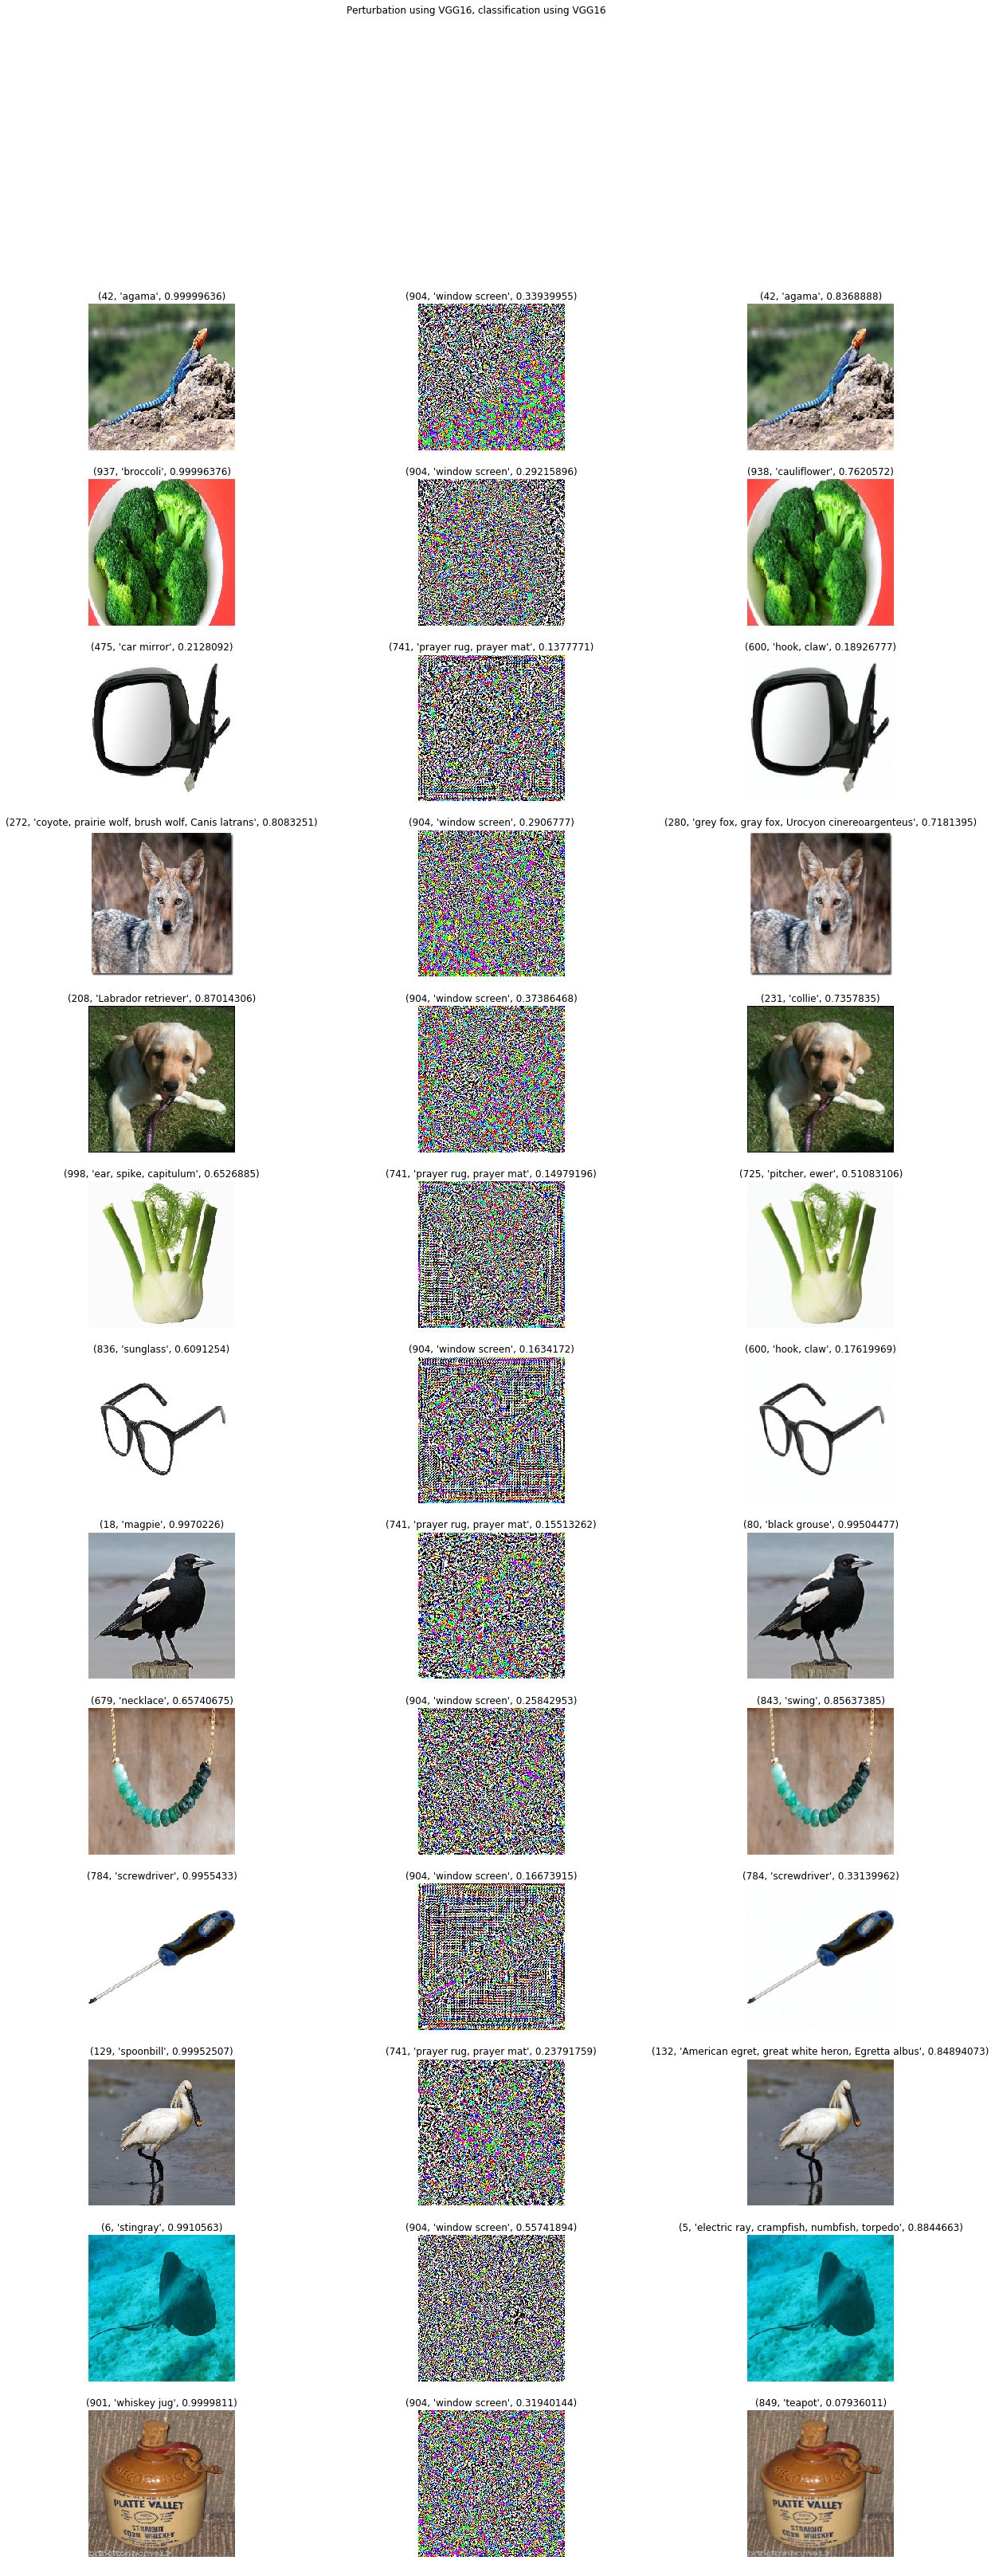

In [21]:
generate_adversarial_examples(folder, 
                              'Perturbation using VGG16, classification using VGG16',
                              perturbation_model = vgg16, display_model = vgg16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

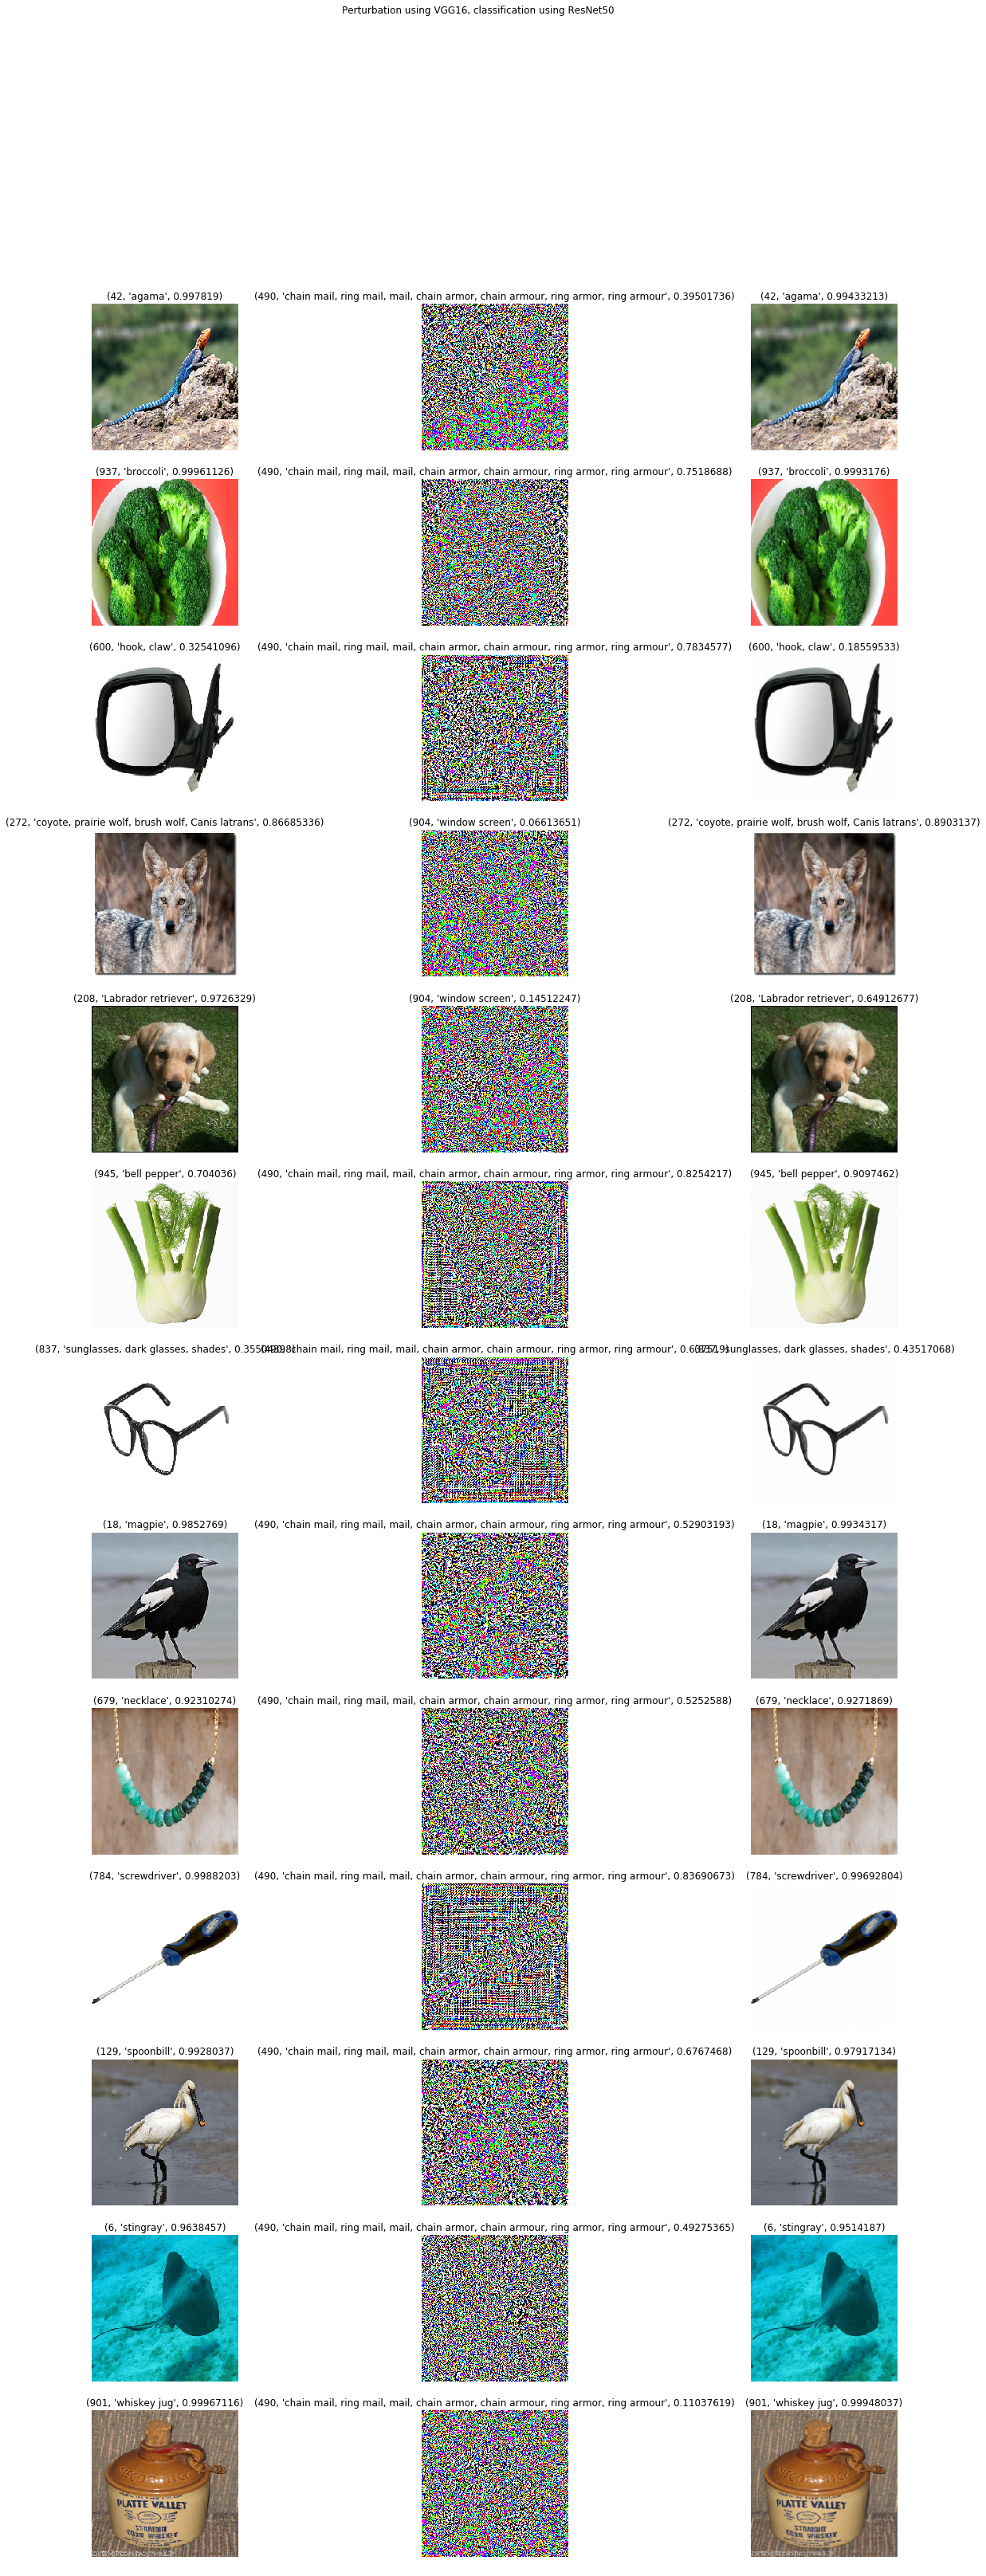

In [22]:
generate_adversarial_examples(folder,
                              'Perturbation using VGG16, classification using ResNet50 ',
                              perturbation_model = vgg16, display_model = resnet50)